# IMO 2 Exam 2

## 1. Question 1

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_excel("/Users/80025078/Desktop/MacIMO/Exam2_IMO2/cellDensityData.xlsx", sheet_name="cellDensity_100G")
df

,Cells,Replicate,hour0,hour12,hour24,hour36,hour48,hour60,hour72,hour84,hour96,hour108,hour120,hour132,hour144,hour156
0,GROUPA,1,2.443279,3.250789,4.481972,4.868345,7.734049,12.14294,21.06834,32.21403,44.97230,59.86086,67.56402,74.98196,79.12743,83.76183
1,GROUPA,2,5.458129,6.323814,7.833822,8.186118,11.849800,17.55985,27.37502,39.06969,55.06044,66.61292,78.64518,86.60606,88.30616,89.75607
2,GROUPA,3,3.494456,4.445971,5.836442,6.729633,10.313300,16.28722,26.19899,36.88338,47.36365,59.45911,67.69543,74.23660,76.18574,82.04500
3,GROUPB,1,3.274191,4.100021,7.650208,13.570770,24.858790,42.08861,64.68105,80.28909,87.74392,93.00857,91.55927,90.62819,92.26931,94.88639
4,GROUPB,2,10.216750,8.546698,12.436260,18.277790,28.753980,48.31666,65.98064,79.85975,87.52779,91.06229,92.51405,94.77900,94.06013,92.70002
5,GROUPB,3,7.414409,8.056905,12.109630,19.180110,32.036880,51.62748,70.18950,84.75351,92.80690,91.03461,93.67191,94.89393,93.62826,92.49529


### Preprocesing

In [3]:
names = list(df.columns)
time = list(map(lambda x: int(x.split('hour')[-1]), names[2:]))
data = df.drop(columns=["Cells","Replicate"])
data.columns = time
data

,0,12,24,36,48,60,72,84,96,108,120,132,144,156
0,2.443279,3.250789,4.481972,4.868345,7.734049,12.14294,21.06834,32.21403,44.97230,59.86086,67.56402,74.98196,79.12743,83.76183
1,5.458129,6.323814,7.833822,8.186118,11.849800,17.55985,27.37502,39.06969,55.06044,66.61292,78.64518,86.60606,88.30616,89.75607
2,3.494456,4.445971,5.836442,6.729633,10.313300,16.28722,26.19899,36.88338,47.36365,59.45911,67.69543,74.23660,76.18574,82.04500
3,3.274191,4.100021,7.650208,13.570770,24.858790,42.08861,64.68105,80.28909,87.74392,93.00857,91.55927,90.62819,92.26931,94.88639
4,10.216750,8.546698,12.436260,18.277790,28.753980,48.31666,65.98064,79.85975,87.52779,91.06229,92.51405,94.77900,94.06013,92.70002
5,7.414409,8.056905,12.109630,19.180110,32.036880,51.62748,70.18950,84.75351,92.80690,91.03461,93.67191,94.89393,93.62826,92.49529


### MLE 

In [4]:
parameters = pd.DataFrame({"cells":[],"replicate":[],"growth rate":[], "carrying capacity":[]})

def parameters_fitting(parameters, group, rep, r, k):
    parameters = pd.concat([parameters, pd.DataFrame({"cells": group, 
                                                        "replicate":int(rep),
                                                        "growth rate":r,
                                                        "carrying capacity":k}, index=[0])])
    return parameters

In [5]:
from scipy.optimize import minimize
from scipy.integrate import odeint
import math
# Define the ODE
def ode_model(y, t, params):
    r = params[0]
    k = params[1]
    dydt = r * y * (1-(y/k))
    return dydt

# Calculate log-likelihood
def log_likelihood(params, t, y):
    y0 = y[0]
    sol = odeint(ode_model, y0, t, args=(params,))
    y_pred = sol[:, 0]
    error = y-y_pred
    sigma = np.std(error)
    n = len(t)
    f = ((1.0/(2.0*math.pi*sigma*sigma))**(n/2))* \
        np.exp(-1*((np.dot(error.T,error))/(2*sigma*sigma)))
    #log_lik = - ((n/2)*np.log(2.0*math.pi*sigma*sigma)) - ((1/(2*sigma*sigma))*np.dot(error.T,error))
    return -1*np.log(f) #-log_lik



In [6]:
# Perform MLE
initial_guess = (0.03, 80)

for i in range(6):
    y_true = data.iloc[i,:]
    result = minimize(log_likelihood, initial_guess, args=(time, y_true))#,method='BFGS')
    r_estimated = result.x[0]
    k_estimated = result.x[1]
    parameters = parameters_fitting(parameters, df.iloc[i,0], df.iloc[i,1], r_estimated, k_estimated)
parameters

,cells,replicate,growth rate,carrying capacity
0,GROUPA,1.0,0.036106,97.953778
0,GROUPA,2.0,0.029115,116.864713
0,GROUPA,3.0,0.033499,95.280367
0,GROUPB,1.0,0.054535,96.350655
0,GROUPB,2.0,0.036707,101.632245
0,GROUPB,3.0,0.044923,98.846004


Calculating the mean and standard error across replicates and fit the mean value.

In [7]:
params_mean = pd.DataFrame({"cells":[], "growth rate":[], "carrying capacity":[]})

def parameters_fitting_mean(params_mean, group, r, k):
    params_mean = pd.concat([params_mean, pd.DataFrame({'cells': group, 
                                                        "growth rate":r,
                                                        "carrying capacity":k}, index=[0])])
    return params_mean

In [8]:
# Perform MLE
initial_guess = (0.09, 50)

y_true_A = data.iloc[0:3,:].mean(axis=0)
y_true_B = data.iloc[3:7,:].mean(axis=0)

result_A = minimize(log_likelihood, initial_guess, args=(time, y_true_A))#,method='BFGS')
r_estimated_A = result_A.x[0]
k_estimated_A = result_A.x[1]

result_B = minimize(log_likelihood, initial_guess, args=(time, y_true_B))#,method='BFGS')
r_estimated_B = result_B.x[0]
k_estimated_B = result_B.x[1]

params_mean = parameters_fitting_mean(params_mean, "GROUPA", r_estimated_A, k_estimated_A)
params_mean = parameters_fitting_mean(params_mean, "GROUPB", r_estimated_B, k_estimated_B)
params_mean

,cells,growth rate,carrying capacity
0,GROUPA,0.032289,103.716168
0,GROUPB,0.043785,98.981869


### Plots:

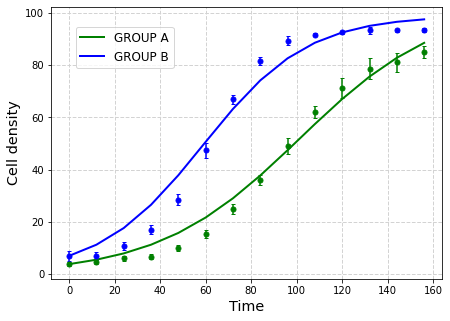

In [9]:
fig, axes = plt.subplots(figsize=(7, 5))

stderr_A = data.iloc[0:3,:].sem(axis=0)
stderr_B = data.iloc[3:7,:].sem(axis=0)

axes.grid(color='#D3D3D3', linestyle='--', linewidth=1)
axes.errorbar(time,y_true_A,yerr = [stderr_A, stderr_A],fmt = 'go', ms=5, capsize = 2)
axes.errorbar(time,y_true_B,yerr = [stderr_B, stderr_B],fmt = 'bo', ms=5, capsize = 2)

r_A = params_mean.loc[params_mean["cells"] == "GROUPA"]["growth rate"]
r_B = params_mean.loc[params_mean["cells"] == "GROUPB"]["growth rate"]
k_A = params_mean.loc[params_mean["cells"] == "GROUPA"]["carrying capacity"]
k_B = params_mean.loc[params_mean["cells"] == "GROUPB"]["carrying capacity"]

sol_A = odeint(ode_model, y_true_A[0], time, args=((r_A,k_A),))
sol_B = odeint(ode_model, y_true_B[0], time, args=((r_B,k_B),))

axes.plot(time,sol_A[:, 0],'g-', linewidth=2,label= 'GROUP A')
axes.plot(time,sol_B[:, 0],'b-', linewidth=2,label= 'GROUP B')
axes.set_xlabel("Time", size = "x-large")
axes.set_ylabel("Cell density", size = "x-large")
plt.legend(bbox_to_anchor=(0.047, 0.95), loc='upper left', fontsize=12)
#plt.savefig("./Q1a.pdf", format="pdf", bbox_inches="tight", dpi = 300)


/var/folders/qn/x0ffm5fs4xd4ld8v40q7lvx0002nl6/T/ipykernel_33649/1276942209.py:9: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  arr1 = axs[0].scatter(x_1,y_1, marker="*", s=200, edgecolor='black', facecolor='yellow')
/var/folders/qn/x0ffm5fs4xd4ld8v40q7lvx0002nl6/T/ipykernel_33649/1276942209.py:9: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  arr1 = axs[0].scatter(x_1,y_1, marker="*", s=200, edgecolor='black', facecolor='yellow')
/var/folders/qn/x0ffm5fs4xd4ld8v40q7lvx0002nl6/T/ipykernel_33649/1276942209.py:10: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units inst

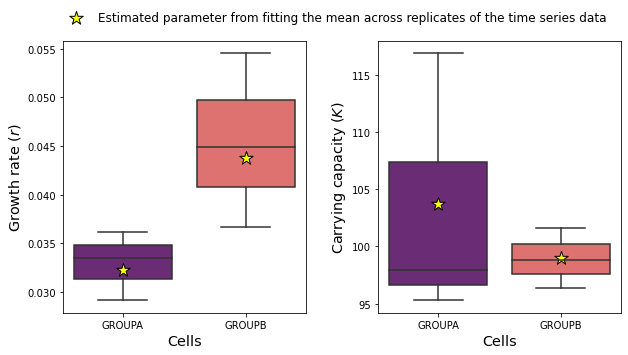

In [10]:
import seaborn as sns

fig, axs = plt.subplots(1,2,figsize=(10, 5))
x_1 = ["GROUPA","GROUPB"]
y_1 =  [r_A,r_B]
y_2 =  [k_A,k_B]
r_ = sns.boxplot(x = "cells", y = 'growth rate', data = parameters, ax=axs[0], palette = "magma")
k_ = sns.boxplot(x = "cells", y = 'carrying capacity', data = parameters, ax=axs[1], palette = "magma")
arr1 = axs[0].scatter(x_1,y_1, marker="*", s=200, edgecolor='black', facecolor='yellow')
axs[1].scatter(x_1,y_2, marker="*", s=200, edgecolor='black', facecolor='yellow')
r_.set_xlabel("Cells",fontsize="x-large")
r_.set_ylabel("Growth rate $(r)$",fontsize="x-large")
k_.set_xlabel("Cells",fontsize="x-large")
k_.set_ylabel("Carrying capacity $(K)$",fontsize="x-large")

fig.subplots_adjust(hspace=0.5, wspace=0.3)

leg = plt.legend([arr1],["Estimated parameter from fitting the mean across replicates of the time series data "],bbox_to_anchor=(1.0, 1.15), loc='best', fontsize="large")
leg.get_frame().set_linewidth(0.0)
#plt.savefig("./Q1b.pdf", format="pdf", bbox_inches="tight", dpi = 300)


## 2. Question 2

In [11]:
def proliferation_rate(r0,g,rho): #r
    return r0*g/(rho+g)

def consumption_rate(r,alpha): #m
    return alpha*r

def ode_model_2(y, t, params):
    r0, k, alpha, rho = params
    n, g = y
    r = proliferation_rate(r0,g,rho) #r(g)
    m = consumption_rate(r,alpha) # m(r)
    dndt = r * n * (1-(n/k))
    dgdt = - m * n * g
    return [dndt, dgdt]

In [12]:
n0 = 2.5
g0 = 500
t = [i for i in range(600)]
r0 = 0.05
k = 50
alpha = 0.1
rho = 0.1
ps = (r0,k,alpha,rho)
sol = odeint(ode_model_2, [n0,g0], t, args=(ps,))
nsol = sol[:,0]
gsol = sol[:,1]

(0.0, 55.0)

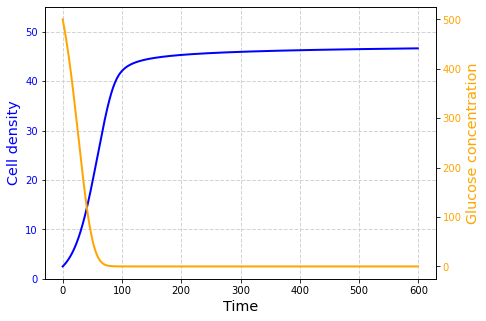

In [13]:
fig, ax1 = plt.subplots(figsize=(7, 5))

ax1.grid(color='#D3D3D3', linestyle='--', linewidth=1)
ax1.plot(t, nsol, color='blue', linewidth=2)

# set axis labels and title
ax1.set_xlabel('Time', fontsize="x-large")
ax1.set_ylabel('Cell density', color='blue', fontsize="x-large")
ax1.tick_params(axis='y', labelcolor='blue')

# create a second axis object that shares the same x-axis as the first one
ax2 = ax1.twinx()

ax2.plot(t,gsol, color='orange', linewidth=2) #, linestyle='dashed', linewidth=2)

# set axis label for the second y-axis
ax2.set_ylabel('Glucose concentration', color='orange', fontsize="x-large")
ax2.tick_params(axis='y', labelcolor='orange')
ax1.set_ylim(0, 55)
#plt.savefig("./Q2.pdf", format="pdf", bbox_inches="tight", dpi = 300)

## 3. Question 3

### Data preprocesing

In [14]:
df2 = pd.read_excel('/Users/80025078/Desktop/MacIMO/Exam2_IMO2/cellDensityData.xlsx', sheet_name="cellDensity_20G")
df2

,Cells,Replicate,hour0,hour12,hour24,hour36,hour48,hour60,hour72,hour84,hour96,hour108,hour120,hour132,hour144,hour156
0,GROUPA,1,6.415966,6.938275,7.195338,9.197824,12.16405,16.83279,23.98072,33.22687,39.74795,46.73240,50.68808,50.21015,58.46032,62.17439
1,GROUPA,2,5.303269,6.018321,6.912330,8.166972,12.49883,17.99416,24.87173,32.89597,37.19453,45.02559,48.62330,51.49867,54.06356,55.45363
2,GROUPA,3,4.406152,4.834653,6.016876,6.765580,11.52146,17.27689,25.65510,34.52198,40.71894,39.96163,43.54217,44.18932,49.06653,54.45425
3,GROUPB,1,4.210460,5.409231,9.291017,14.511280,21.61370,32.26753,42.70742,41.86229,40.35660,46.22045,47.91729,53.24085,53.72391,53.30634
4,GROUPB,2,4.746491,5.169304,9.414597,16.083420,24.53196,36.35817,38.59912,46.50562,45.17684,47.54516,52.74606,55.95649,57.35600,58.04895
5,GROUPB,3,8.671527,9.370955,13.046210,19.243340,26.47089,36.59128,41.96463,42.83715,44.87990,48.61379,54.28661,51.83324,55.99739,57.43152


In [15]:
data2 = df2.drop(columns=["Cells","Replicate"])
data2

,hour0,hour12,hour24,hour36,hour48,hour60,hour72,hour84,hour96,hour108,hour120,hour132,hour144,hour156
0,6.415966,6.938275,7.195338,9.197824,12.16405,16.83279,23.98072,33.22687,39.74795,46.73240,50.68808,50.21015,58.46032,62.17439
1,5.303269,6.018321,6.912330,8.166972,12.49883,17.99416,24.87173,32.89597,37.19453,45.02559,48.62330,51.49867,54.06356,55.45363
2,4.406152,4.834653,6.016876,6.765580,11.52146,17.27689,25.65510,34.52198,40.71894,39.96163,43.54217,44.18932,49.06653,54.45425
3,4.210460,5.409231,9.291017,14.511280,21.61370,32.26753,42.70742,41.86229,40.35660,46.22045,47.91729,53.24085,53.72391,53.30634
4,4.746491,5.169304,9.414597,16.083420,24.53196,36.35817,38.59912,46.50562,45.17684,47.54516,52.74606,55.95649,57.35600,58.04895
5,8.671527,9.370955,13.046210,19.243340,26.47089,36.59128,41.96463,42.83715,44.87990,48.61379,54.28661,51.83324,55.99739,57.43152


In [16]:
complete_data = {"100": data, "20": data2}
complete_data.keys()

dict_keys(['100', '20'])

In [17]:
j = 0
glucose = []
for i in complete_data.keys(): # 2 glucose concentrations
    GA = complete_data[i].iloc[0:3,:].mean(axis=0).to_numpy() #GroupA
    GB = complete_data[i].iloc[3:7,:].mean(axis=0).to_numpy() #GroupB

    GA_sem = complete_data[i].iloc[0:3,:].sem(axis=0).to_numpy() #Standard error of the mean 
    GB_sem = complete_data[i].iloc[3:7,:].sem(axis=0).to_numpy() #Standard error of the mean
    std_errors_prep = np.column_stack((GA_sem , GB_sem))
    data_prep = np.column_stack((GA , GB))

    glucose.append(int(i))
    glucose.append(int(i))

    if j == 0: 
        data_f = data_prep
        std_errors = std_errors_prep
    else: 
        data_f = np.concatenate((data_f, data_prep), axis=1)
        std_errors = np.concatenate((std_errors, std_errors_prep), axis=1)

    j += 1

glucose = np.array(glucose)

### **3.a**

In [18]:
from scipy.optimize import minimize
from scipy.integrate import odeint
import math

def model1(y, t, params):
    
    y1,y2, y3, y4 = y
    r1, k1, r2, k2, r3, k3, r4, k4 = params

    dy1dt = r1 * y1 * (1-(y1/k1))
    dy2dt = r2 * y2 * (1-(y2/k2))
    dy3dt = r3 * y3 * (1-(y3/k3))
    dy4dt = r4 * y4 * (1-(y4/k4))

    return [dy1dt, dy2dt, dy3dt, dy4dt]

def log_likelihood_1(params, t, y):
    y0 = y[0]
    sol = odeint(model1, y0, t, args=(params,))
    y_pred = sol
    error = (y-y_pred).ravel()
    sigma = np.std(error)
    n = len(t)
    f = ((1.0/(2.0*math.pi*sigma*sigma))**(n/2))* \
        np.exp(-1*((np.dot(error.T,error))/(2*sigma*sigma)))
    return -1*np.log(f)

In [19]:

initial_guess_1 = (0.03, 80, 0.03, 80,0.03, 80, 0.03, 80)
result = minimize(log_likelihood_1, initial_guess_1, args=(time, data_f))


In [20]:
param_names = ['r1', 'k1', 'r2', 'k2', 'r3', 'k3', 'r4', 'k4']

print('--------------------')
print('Parameter    Value')
for i in range(len(param_names)):
    print(f"{param_names[i]:7s} {result.x[i]:11.5f}")

--------------------
Parameter    Value
r1          0.03190
k1        103.95822
r2          0.04338
k2         98.32693
r3          0.02639
k3         67.49603
r4          0.03916
k4         55.04203


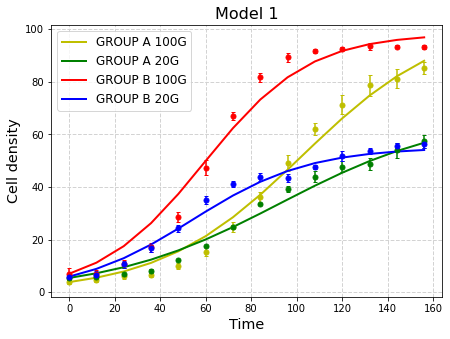

In [21]:
fig, axes = plt.subplots(figsize=(7, 5))

stderr_A_20 = data2.iloc[0:3,:].sem(axis=0)
stderr_B_20 = data2.iloc[3:7,:].sem(axis=0)
stderr_A_100 = data.iloc[0:3,:].sem(axis=0)
stderr_B_100 = data.iloc[3:7,:].sem(axis=0)

axes.grid(color='#D3D3D3', linestyle='--', linewidth=1)
axes.errorbar(time,data_f[:,0],yerr = [stderr_A_100, stderr_A_100],fmt = 'yo', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,1],yerr = [stderr_B_100, stderr_B_100],fmt = 'ro', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,2],yerr = [stderr_A_20, stderr_A_20],fmt = 'go', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,3],yerr = [stderr_B_20, stderr_B_20],fmt = 'bo', ms=5, capsize = 2)

pars = result.x

sol_1 = odeint(model1, data_f[0], time, args=(pars,))

axes.plot(time,sol_1[:, 0],'y-', linewidth=2,label= 'GROUP A 100G')
axes.plot(time,sol_1[:, 2],'g-', linewidth=2,label= 'GROUP A 20G')
axes.plot(time,sol_1[:, 1],'r-', linewidth=2,label= 'GROUP B 100G')
axes.plot(time,sol_1[:, 3],'b-', linewidth=2,label= 'GROUP B 20G')


axes.set_xlabel("Time", size = "x-large")
axes.set_ylabel("Cell density", size = "x-large")
plt.legend(loc='upper left', fontsize=12)
plt.title("Model 1", fontsize=16)
plt.savefig("./Q3Model1.pdf", format="pdf", bbox_inches="tight", dpi = 300)

In [22]:
# initial_guess_2 = (0.03, 80, 0.1, 0.1, 0.03, 80, 0.1, 0.1, 0.03, 80, 0.1, 0.1, 0.03, 80, 0.1, 0.1)
# data_g = np.insert(data_f, 0, glucose)
# data_g = data_g.reshape(15,4)
# data_g

In [23]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


def func(xs, t, ps):
    """Migration model."""
    try:
        #A_100
        r01     = ps['r01'].value 
        k1     = ps['k1'].value
        alpha1 = ps['alpha1'].value
        rho1   = ps['rho1'].value
        #B_100
        r02     = ps['r02'].value 
        k2     = ps['k2'].value
        alpha2 = ps['alpha2'].value
        rho2   = ps['rho2'].value
        #A_20
        k3     = ps['k3'].value
        alpha3 = ps['alpha3'].value
        rho3   = ps['rho3'].value        
        #B_20
        k4     = ps['k4'].value
        alpha4 = ps['alpha4'].value
        rho4   = ps['rho4'].value

    except:
        r01, k1, alpha1, rho1, r02, k2, alpha2, rho2, k3, alpha3, rho3, k4, alpha4, rho4 = ps

    n1, n2, n3, n4, g1, g2, g3, g4 = xs  #x is Top alive, y is Bottom alive, z is Top dead

    def proliferation_rate(r0,g,rho): #r
        return r0*g/(rho+g)

    def consumption_rate(r,alpha): #m
        return alpha*r


    r1 = proliferation_rate(r01,g1,rho1) #r(g)
    m1 = consumption_rate(r1,alpha1) # m(r)
    dn1dt = r1 * n1 * (1-(n1/k1))
    dg1dt = - m1 * n1 * g1

    r2 = proliferation_rate(r02,g2,rho2) #r(g)
    m2 = consumption_rate(r2,alpha2) # m(r)
    dn2dt = r2 * n2 * (1-(n2/k2))
    dg2dt = - m2 * n2 * g2

    r3 = proliferation_rate(r01,g3,rho3) #r(g)
    m3 = consumption_rate(r3,alpha3) # m(r)
    dn3dt = r3 * n3 * (1-(n3/k3))
    dg3dt = - m3 * n3 * g3

    r4 = proliferation_rate(r02,g4,rho4) #r(g)
    m4 = consumption_rate(r4,alpha4) # m(r)
    dn4dt = r4 * n4 * (1-(n4/k4))
    dg4dt = - m4 * n4 * g4

    return [dn1dt, dn2dt, dn3dt , dn4dt, dg1dt , dg2dt, dg3dt, dg4dt]



def log_likelihood2(params, t, y, g):
    y0 = np.insert(g, 0, y[0])
    sol = odeint(func, y0, t, args=(params,))
    y_pred = sol[:,0:4]
    error = (y-y_pred).ravel()
    sigma = np.std(error)
    n = len(t)
    f = ((1.0/(2.0*math.pi*sigma*sigma))**(n/2))* \
        np.exp(-1*((np.dot(error.T,error))/(2*sigma*sigma)))
    return -1*np.log(f)

In [24]:
#params["r01"].vary = False

In [25]:
#params["r01"].vary

In [26]:

params = Parameters()
params.add('r01', value=0.03, min=0, max = 2)
params.add('k1', value=80, min= 75, max = 110)
params.add('alpha1', value=0.1, min = 0.0001, max=5)
params.add('rho1', value=0.1, min=0.0000001)
params.add('r02', value=0.03, min=0, max = 2)
params.add('k2', value=80, min= 75, max = 110)
params.add('alpha2', value=0.1,min = 0.0001, max=5)
params.add('rho2', value=0.1, min=0.0000001)
params.add('k3', value=50, min= 40, max=110)
params.add('alpha3', value=0.1,min = 0.0001, max=5)
params.add('rho3', value=0.1, min=0.0000001)
params.add('k4', value=50, min= 40, max=110)
params.add('alpha4', value=0.1,min = 0.0001, max=5)
params.add('rho4', value=0.1, min=0.0000001)
#vary=True

# fit model and find predicted values
result = minimize(log_likelihood2, params, args=(np.array(time), data_f, glucose), method='BFGS')

# print('--------------------')
# print('Parameter    Value')
# for name, param in result.params.items():
#     print(f"{name:7s} {param.value:11.5f}")

In [27]:
result.params

name,value,initial value,min,max,vary
r01,0.03982180,0.03,0.00000000,2.00000000,True
k1,99.2038096,80,75.0000000,110.000000,True
alpha1,1.0000e-04,0.1,1.0000e-04,5.00000000,True
rho1,13.3384210,0.1,1.0000e-07,inf,True
r02,0.04364732,0.03,0.00000000,2.00000000,True
k2,110.000000,80,75.0000000,110.000000,True
alpha2,0.11850842,0.1,1.0000e-04,5.00000000,True
rho2,1.0001e-07,0.1,1.0000e-07,inf,True
k3,65.8480636,50,40.0000000,110.000000,True
alpha3,1.0000e-04,0.1,1.0000e-04,5.00000000,True


In [28]:
par_sol = []
for name, param in result.params.items():
    par_sol.append(param.value)

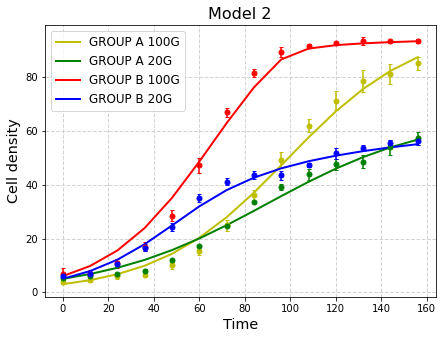

In [29]:
fig, axes = plt.subplots(figsize=(7, 5))

stderr_A_20 = data2.iloc[0:3,:].sem(axis=0)
stderr_B_20 = data2.iloc[3:7,:].sem(axis=0)
stderr_A_100 = data.iloc[0:3,:].sem(axis=0)
stderr_B_100 = data.iloc[3:7,:].sem(axis=0)

axes.grid(color='#D3D3D3', linestyle='--', linewidth=1)
axes.errorbar(time,data_f[:,0],yerr = [stderr_A_100, stderr_A_100],fmt = 'yo', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,1],yerr = [stderr_B_100, stderr_B_100],fmt = 'ro', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,2],yerr = [stderr_A_20, stderr_A_20],fmt = 'go', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,3],yerr = [stderr_B_20, stderr_B_20],fmt = 'bo', ms=5, capsize = 2)

y0 = np.insert(glucose, 0, data_f[0])
sol_2 = odeint(func, y0, np.array(time), args=(par_sol,))

axes.plot(time,sol_2[:, 0],'y-', linewidth=2,label= 'GROUP A 100G')
axes.plot(time,sol_2[:, 2],'g-', linewidth=2,label= 'GROUP A 20G')
axes.plot(time,sol_2[:, 1],'r-', linewidth=2,label= 'GROUP B 100G')
axes.plot(time,sol_2[:, 3],'b-', linewidth=2,label= 'GROUP B 20G')


axes.set_xlabel("Time", size = "x-large")
axes.set_ylabel("Cell density", size = "x-large")
plt.legend(loc='upper left', fontsize=12)
plt.title("Model 2", fontsize=16)
plt.savefig("./Q3Model2.pdf", format="pdf", bbox_inches="tight", dpi = 300)

#### **Model selection**

In [30]:
criteria = pd.DataFrame({"model":[], "criterion":[], "value":[]})

def model_criteria(criteria, model, criterion, val):
    criteria = pd.concat([criteria, pd.DataFrame({'model': str(model), 
                                                        "criterion": str(criterion),
                                                        "value": val}, index=[0])])
    return criteria

In [31]:
def AIC(lk,d):
    return 2*(d-lk)

def BIC(lk,d,n):
    return (np.log(n)*d) - (2*lk)

In [32]:
from sklearn.metrics import r2_score

# n is the number of data points
lk1 = -1*log_likelihood_1(pars, time, data_f)
d1 = len(pars)
n = len(data_f.ravel())
lk2 = -1*log_likelihood2(par_sol, time, data_f, glucose)
d2 = len(par_sol)


criteria = model_criteria(criteria, "Model1", "AIC", AIC(lk1,d1))
criteria = model_criteria(criteria, "Model2", "AIC", AIC(lk2,d2))
criteria = model_criteria(criteria, "Model1", "BIC", BIC(lk1,d1, n))
criteria = model_criteria(criteria, "Model2", "BIC", BIC(lk2,d2, n))
criteria

,model,criterion,value
0,Model1,AIC,134.966598
0,Model2,AIC,138.184307
0,Model1,BIC,151.169412
0,Model2,BIC,166.539230


In [33]:
print('------- How well was the fit -------')
print('Model    Value')
print(f"1     {r2_score(data_f.ravel(), sol_1.ravel()):11.5f}")
print(f"2     {r2_score(data_f.ravel(), sol_2[:,0:4].ravel()):11.5f}")

------- How well was the fit -------
Model    Value
1         0.98353
2         0.99117


In [34]:
aic = criteria.loc[criteria['criterion'] == "AIC"]['value'].to_numpy()
bic = criteria.loc[criteria['criterion'] == "BIC"]['value'].to_numpy()

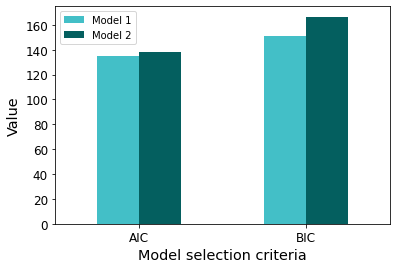

In [35]:
plotdata = pd.DataFrame({
    "Model 1": [aic[0], bic[0]],
    "Model 2":[aic[1], bic[1]],
    }, 
    index=["AIC", "BIC"]
)
plotdata.plot.bar(color=["#43BFC7","#045F5F"])
plt.xticks(rotation=0, horizontalalignment="center", size = 'large')
plt.yticks(size = 'large')
plt.xlabel("Model selection criteria", size = 'x-large')
plt.ylabel("Value", size = 'x-large')
plt.legend(loc = 'upper left',fontsize = 10)
plt.savefig("./Q3ModelSelection1.pdf", format="pdf", bbox_inches="tight", dpi = 300)

"Lower BIC (or AIC) value indicates lower penalty terms hence a better model."

"Though BIC is always higher than AIC, lower the value of these two measures, better the model."


### **3.d**

#### Keeping the K constant across glucose but different for cell types (model 3)

In [36]:
def func3(xs, t, ps):
    """Migration model."""
    try:
        #A_100
        r01     = ps['r01'].value 
        k1     = ps['k1'].value
        alpha1 = ps['alpha1'].value
        rho1   = ps['rho1'].value
        #B_100
        r02     = ps['r02'].value 
        k2     = ps['k2'].value
        alpha2 = ps['alpha2'].value
        rho2   = ps['rho2'].value
        #A_20
        alpha3 = ps['alpha3'].value
        rho3   = ps['rho3'].value        
        #B_20
        alpha4 = ps['alpha4'].value
        rho4   = ps['rho4'].value

    except:
        r01, k1, alpha1, rho1, r02, k2, alpha2, rho2, alpha3, rho3, alpha4, rho4 = ps

    n1, n2, n3, n4, g1, g2, g3, g4 = xs  #x is Top alive, y is Bottom alive, z is Top dead

    def proliferation_rate(r0,g,rho): #r
        return r0*g/(rho+g)

    def consumption_rate(r,alpha): #m
        return alpha*r


    r1 = proliferation_rate(r01,g1,rho1) #r(g)
    m1 = consumption_rate(r1,alpha1) # m(r)
    dn1dt = r1 * n1 * (1-(n1/k1))
    dg1dt = - m1 * n1 * g1

    r2 = proliferation_rate(r02,g2,rho2) #r(g)
    m2 = consumption_rate(r2,alpha2) # m(r)
    dn2dt = r2 * n2 * (1-(n2/k2))
    dg2dt = - m2 * n2 * g2

    r3 = proliferation_rate(r01,g3,rho3) #r(g)
    m3 = consumption_rate(r3,alpha3) # m(r)
    dn3dt = r3 * n3 * (1-(n3/k1))
    dg3dt = - m3 * n3 * g3

    r4 = proliferation_rate(r02,g4,rho4) #r(g)
    m4 = consumption_rate(r4,alpha4) # m(r)
    dn4dt = r4 * n4 * (1-(n4/k2))
    dg4dt = - m4 * n4 * g4

    return [dn1dt, dn2dt, dn3dt , dn4dt, dg1dt , dg2dt, dg3dt, dg4dt]



def log_likelihood3(params, t, y, g):
    y0 = np.insert(g, 0, y[0])
    sol = odeint(func3, y0, t, args=(params,))
    y_pred = sol[:,0:4]
    error = (y-y_pred).ravel()
    sigma = np.std(error)
    n = len(t)
    f = ((1.0/(2.0*math.pi*sigma*sigma))**(n/2))* \
        np.exp(-1*((np.dot(error.T,error))/(2*sigma*sigma)))
    return -1*np.log(f)

params = Parameters()
params = Parameters()
params.add('r01', value=0.03, min=0, max = 2)
params.add('k1', value=80, min= 75, max = 110)
params.add('alpha1', value=0.1, min = 0.0001, max=5)
params.add('rho1', value=0.1, min=0.0000001)
params.add('r02', value=0.03, min=0, max = 2)
params.add('k2', value=80, min= 75, max = 110)
params.add('alpha2', value=0.1,min = 0.0001, max=5)
params.add('rho2', value=0.1, min=0.0000001)
params.add('alpha3', value=0.1,min = 0.0001, max=5)
params.add('rho3', value=0.1, min=0.0000001)
params.add('alpha4', value=0.1,min = 0.0001, max=5)
params.add('rho4', value=0.1, min=0.0000001)

#vary=True

# fit model and find predicted values
result = minimize(log_likelihood3, params, args=(np.array(time), data_f, glucose), method='BFGS')



In [37]:
result.params

name,value,initial value,min,max,vary
r01,0.03420571,0.03,0.00000000,2.00000000,True
k1,110.000000,80,75.0000000,110.000000,True
alpha1,0.10472951,0.1,1.0000e-04,5.00000000,True
rho1,5.2142e-05,0.1,1.0000e-07,inf,True
r02,0.04607662,0.03,0.00000000,2.00000000,True
k2,97.7980012,80,75.0000000,110.000000,True
alpha2,0.00116795,0.1,1.0000e-04,5.00000000,True
rho2,6.6427e-05,0.1,1.0000e-07,inf,True
alpha3,0.03094185,0.1,1.0000e-04,5.00000000,True
rho3,5.25733313,0.1,1.0000e-07,inf,True


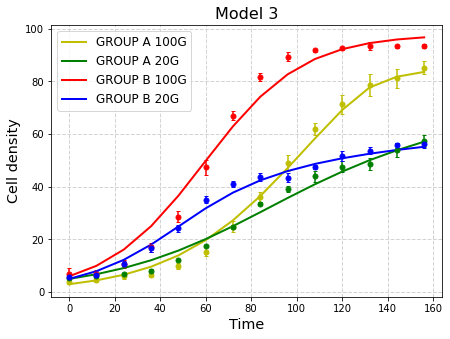

In [38]:
par_sol = []
for name, param in result.params.items():
    par_sol.append(param.value)

fig, axes = plt.subplots(figsize=(7, 5))

stderr_A_20 = data2.iloc[0:3,:].sem(axis=0)
stderr_B_20 = data2.iloc[3:7,:].sem(axis=0)
stderr_A_100 = data.iloc[0:3,:].sem(axis=0)
stderr_B_100 = data.iloc[3:7,:].sem(axis=0)

axes.grid(color='#D3D3D3', linestyle='--', linewidth=1)
axes.errorbar(time,data_f[:,0],yerr = [stderr_A_100, stderr_A_100],fmt = 'yo', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,1],yerr = [stderr_B_100, stderr_B_100],fmt = 'ro', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,2],yerr = [stderr_A_20, stderr_A_20],fmt = 'go', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,3],yerr = [stderr_B_20, stderr_B_20],fmt = 'bo', ms=5, capsize = 2)

y0 = np.insert(glucose, 0, data_f[0])
sol_2 = odeint(func3, y0, np.array(time), args=(par_sol,))

axes.plot(time,sol_2[:, 0],'y-', linewidth=2,label= 'GROUP A 100G')
axes.plot(time,sol_2[:, 2],'g-', linewidth=2,label= 'GROUP A 20G')
axes.plot(time,sol_2[:, 1],'r-', linewidth=2,label= 'GROUP B 100G')
axes.plot(time,sol_2[:, 3],'b-', linewidth=2,label= 'GROUP B 20G')


axes.set_xlabel("Time", size = "x-large")
axes.set_ylabel("Cell density", size = "x-large")
plt.legend(loc='upper left', fontsize=12)
plt.title("Model 3", fontsize=16)
plt.savefig("./Q3Model3.pdf", format="pdf", bbox_inches="tight", dpi = 300)

In [39]:
# n is the number of data points
n = len(data_f.ravel())
lk3 = -1*log_likelihood3(par_sol, time, data_f, glucose)
d3 = len(par_sol)


criteria = model_criteria(criteria, "Model3", "AIC", AIC(lk3,d3))
criteria = model_criteria(criteria, "Model3", "BIC", BIC(lk3,d3, n))
criteria

,model,criterion,value
0,Model1,AIC,134.966598
0,Model2,AIC,138.184307
0,Model1,BIC,151.169412
0,Model2,BIC,166.539230
0,Model3,AIC,137.273733
0,Model3,BIC,161.577953


#### Parameter fixing over cell types

##### r0 constant (model4)

In [40]:
def func4(xs, t, ps):
    """Migration model."""
    try:
        #A_100
        r01     = ps['r01'].value 
        k1     = ps['k1'].value
        alpha1 = ps['alpha1'].value
        rho1   = ps['rho1'].value
        #B_100
        k2     = ps['k2'].value
        alpha2 = ps['alpha2'].value
        rho2   = ps['rho2'].value
        #A_20
        k3     = ps['k3'].value
        alpha3 = ps['alpha3'].value
        rho3   = ps['rho3'].value        
        #B_20
        k4     = ps['k4'].value
        alpha4 = ps['alpha4'].value
        rho4   = ps['rho4'].value

    except:
        r01, k1, alpha1, rho1, k2, alpha2, rho2, k3, alpha3, rho3, k4, alpha4, rho4 = ps

    n1, n2, n3, n4, g1, g2, g3, g4 = xs  #x is Top alive, y is Bottom alive, z is Top dead

    def proliferation_rate(r0,g,rho): #r
        return r0*g/(rho+g)

    def consumption_rate(r,alpha): #m
        return alpha*r


    r1 = proliferation_rate(r01,g1,rho1) #r(g)
    m1 = consumption_rate(r1,alpha1) # m(r)
    dn1dt = r1 * n1 * (1-(n1/k1))
    dg1dt = - m1 * n1 * g1

    r2 = proliferation_rate(r01,g2,rho2) #r(g)
    m2 = consumption_rate(r2,alpha2) # m(r)
    dn2dt = r2 * n2 * (1-(n2/k2))
    dg2dt = - m2 * n2 * g2

    r3 = proliferation_rate(r01,g3,rho3) #r(g)
    m3 = consumption_rate(r3,alpha3) # m(r)
    dn3dt = r3 * n3 * (1-(n3/k3))
    dg3dt = - m3 * n3 * g3

    r4 = proliferation_rate(r01,g4,rho4) #r(g)
    m4 = consumption_rate(r4,alpha4) # m(r)
    dn4dt = r4 * n4 * (1-(n4/k4))
    dg4dt = - m4 * n4 * g4

    return [dn1dt, dn2dt, dn3dt , dn4dt, dg1dt , dg2dt, dg3dt, dg4dt]


def log_likelihood4(params, t, y, g):
    y0 = np.insert(g, 0, y[0])
    sol = odeint(func4, y0, t, args=(params,))
    y_pred = sol[:,0:4]
    error = (y-y_pred).ravel()
    sigma = np.std(error)
    n = len(t)
    f = ((1.0/(2.0*math.pi*sigma*sigma))**(n/2))* \
        np.exp(-1*((np.dot(error.T,error))/(2*sigma*sigma)))
    return -1*np.log(f)

params = Parameters()
params.add('r01', value=0.03, min=0, max = 2)
params.add('k1', value=80, min= 40, max=110)
params.add('alpha1', value=0.1, min = 0.0001, max=5)
params.add('rho1', value=0.1, min=0.0000001)
params.add('k2', value=80, min= 40, max = 110)
params.add('alpha2', value=0.1,min = 0.0001, max=5)
params.add('rho2', value=0.1, min=0.0000001)
params.add('k3', value=50, min= 40, max=110)
params.add('alpha3', value=0.1,min = 0.0001, max=5)
params.add('rho3', value=0.1, min=0.0000001)
params.add('k4', value=50, min= 40, max=110)
params.add('alpha4', value=0.1,min = 0.0001, max=5)
params.add('rho4', value=0.1, min=0.0000001)

#vary=True

# fit model and find predicted values
result = minimize(log_likelihood4, params, args=(np.array(time), data_f, glucose), method='BFGS')
result.params

name,value,initial value,min,max,vary
r01,0.04360136,0.03,0.00000000,2.00000000,True
k1,99.2310520,80,40.0000000,110.000000,True
alpha1,1.0000e-04,0.1,1.0000e-04,5.00000000,True
rho1,24.0630149,0.1,1.0000e-07,inf,True
k2,110.000000,80,40.0000000,110.000000,True
alpha2,0.11843734,0.1,1.0000e-04,5.00000000,True
rho2,1.0000e-07,0.1,1.0000e-07,inf,True
k3,65.8552488,50,40.0000000,110.000000,True
alpha3,1.0000e-04,0.1,1.0000e-04,5.00000000,True
rho3,11.2972949,0.1,1.0000e-07,inf,True


In [41]:
par_sol = []
for name, param in result.params.items():
    par_sol.append(param.value)

# n is the number of data points
n = len(data_f.ravel())
lk4 = -1*log_likelihood4(par_sol, time, data_f, glucose)
d4 = len(par_sol)


criteria = model_criteria(criteria, "Model4", "AIC", AIC(lk4,d4))
criteria = model_criteria(criteria, "Model4", "BIC", BIC(lk4,d4, n))
criteria

,model,criterion,value
0,Model1,AIC,134.966598
0,Model2,AIC,138.184307
0,Model1,BIC,151.169412
0,Model2,BIC,166.539230
0,Model3,AIC,137.273733
0,Model3,BIC,161.577953
0,Model4,AIC,136.836334
0,Model4,BIC,163.165906


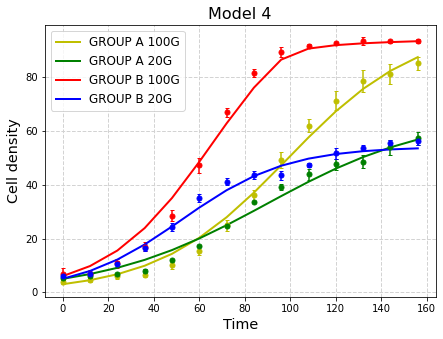

In [42]:
fig, axes = plt.subplots(figsize=(7, 5))

stderr_A_20 = data2.iloc[0:3,:].sem(axis=0)
stderr_B_20 = data2.iloc[3:7,:].sem(axis=0)
stderr_A_100 = data.iloc[0:3,:].sem(axis=0)
stderr_B_100 = data.iloc[3:7,:].sem(axis=0)

axes.grid(color='#D3D3D3', linestyle='--', linewidth=1)
axes.errorbar(time,data_f[:,0],yerr = [stderr_A_100, stderr_A_100],fmt = 'yo', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,1],yerr = [stderr_B_100, stderr_B_100],fmt = 'ro', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,2],yerr = [stderr_A_20, stderr_A_20],fmt = 'go', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,3],yerr = [stderr_B_20, stderr_B_20],fmt = 'bo', ms=5, capsize = 2)

y0 = np.insert(glucose, 0, data_f[0])
sol_4 = odeint(func4, y0, np.array(time), args=(par_sol,))

axes.plot(time,sol_4[:, 0],'y-', linewidth=2,label= 'GROUP A 100G')
axes.plot(time,sol_4[:, 2],'g-', linewidth=2,label= 'GROUP A 20G')
axes.plot(time,sol_4[:, 1],'r-', linewidth=2,label= 'GROUP B 100G')
axes.plot(time,sol_4[:, 3],'b-', linewidth=2,label= 'GROUP B 20G')


axes.set_xlabel("Time", size = "x-large")
axes.set_ylabel("Cell density", size = "x-large")
plt.legend(loc='upper left', fontsize=12)
plt.title("Model 4", fontsize=16)
plt.savefig("./Q3Model4.pdf", format="pdf", bbox_inches="tight", dpi = 300)

##### K constant, same between groups and glucose (model5)

In [43]:
def func5(xs, t, ps):
    """Migration model."""
    try:
        #A_100
        r01     = ps['r01'].value 
        k1     = ps['k1'].value
        alpha1 = ps['alpha1'].value
        rho1   = ps['rho1'].value
        #B_100
        r02     = ps['r02'].value 
        alpha2 = ps['alpha2'].value
        rho2   = ps['rho2'].value
        #A_20
        alpha3 = ps['alpha3'].value
        rho3   = ps['rho3'].value        
        #B_20
        alpha4 = ps['alpha4'].value
        rho4   = ps['rho4'].value

    except:
        r01, k1, alpha1, rho1, r02, alpha2, rho2, alpha3, rho3, alpha4, rho4 = ps

    n1, n2, n3, n4, g1, g2, g3, g4 = xs  

    def proliferation_rate(r0,g,rho): #r
        return r0*g/(rho+g)

    def consumption_rate(r,alpha): #m
        return alpha*r


    r1 = proliferation_rate(r01,g1,rho1) #r(g)
    m1 = consumption_rate(r1,alpha1) # m(r)
    dn1dt = r1 * n1 * (1-(n1/k1))
    dg1dt = - m1 * n1 * g1

    r2 = proliferation_rate(r02,g2,rho2) #r(g)
    m2 = consumption_rate(r2,alpha2) # m(r)
    dn2dt = r2 * n2 * (1-(n2/k1))
    dg2dt = - m2 * n2 * g2

    r3 = proliferation_rate(r01,g3,rho3) #r(g)
    m3 = consumption_rate(r3,alpha3) # m(r)
    dn3dt = r3 * n3 * (1-(n3/k1))
    dg3dt = - m3 * n3 * g3

    r4 = proliferation_rate(r02,g4,rho4) #r(g)
    m4 = consumption_rate(r4,alpha4) # m(r)
    dn4dt = r4 * n4 * (1-(n4/k1))
    dg4dt = - m4 * n4 * g4

    return [dn1dt, dn2dt, dn3dt , dn4dt, dg1dt , dg2dt, dg3dt, dg4dt]



def log_likelihood5(params, t, y, g):
    y0 = np.insert(g, 0, y[0])
    sol = odeint(func5, y0, t, args=(params,))
    y_pred = sol[:,0:4]
    error = (y-y_pred).ravel()
    sigma = np.std(error)
    n = len(t)
    f = ((1.0/(2.0*math.pi*sigma*sigma))**(n/2))* \
        np.exp(-1*((np.dot(error.T,error))/(2*sigma*sigma)))
    return -1*np.log(f)


params = Parameters()
params.add('r01', value=0.03, min=0, max = 2)
params.add('k1', value=80, min= 40, max = 110)
params.add('alpha1', value=0.1, min = 0.0001, max=5)
params.add('rho1', value=0.1, min=0.0000001)
params.add('r02', value=0.03, min=0, max = 2)
params.add('alpha2', value=0.1,min = 0.0001, max=5)
params.add('rho2', value=0.1, min=0.0000001)
params.add('alpha3', value=0.1,min = 0.0001, max=5)
params.add('rho3', value=0.1, min=0.0000001)
params.add('alpha4', value=0.1,min = 0.0001, max=5)
params.add('rho4', value=0.1, min=0.0000001)


#vary=True

# fit model and find predicted values
result = minimize(log_likelihood5, params, args=(np.array(time), data_f, glucose), method='BFGS')
result.params

name,value,initial value,min,max,vary
r01,0.03424307,0.03,0.00000000,2.00000000,True
k1,109.999997,80,40.0000000,110.000000,True
alpha1,0.10559276,0.1,1.0000e-04,5.00000000,True
rho1,4.4826e-05,0.1,1.0000e-07,inf,True
r02,0.04366568,0.03,0.00000000,2.00000000,True
alpha2,0.11840447,0.1,1.0000e-04,5.00000000,True
rho2,1.0000e-07,0.1,1.0000e-07,inf,True
alpha3,0.03109165,0.1,1.0000e-04,5.00000000,True
rho3,5.21654507,0.1,1.0000e-07,inf,True
alpha4,0.07117358,0.1,1.0000e-04,5.00000000,True


In [44]:
par_sol = []
for name, param in result.params.items():
    par_sol.append(param.value)

# n is the number of data points
n = len(data_f.ravel())
lk5 = -1*log_likelihood5(par_sol, time, data_f, glucose)
d5 = len(par_sol)


criteria = model_criteria(criteria, "Model5", "AIC", AIC(lk5,d5))
criteria = model_criteria(criteria, "Model5", "BIC", BIC(lk5,d5, n))
criteria

,model,criterion,value
0,Model1,AIC,134.966598
0,Model2,AIC,138.184307
0,Model1,BIC,151.169412
0,Model2,BIC,166.539230
0,Model3,AIC,137.273733
0,Model3,BIC,161.577953
0,Model4,AIC,136.836334
0,Model4,BIC,163.165906
0,Model5,AIC,130.698239
0,Model5,BIC,152.977108


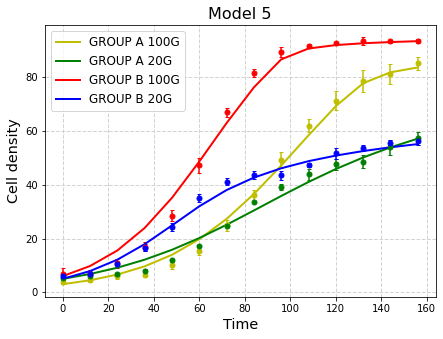

In [45]:
fig, axes = plt.subplots(figsize=(7, 5))

stderr_A_20 = data2.iloc[0:3,:].sem(axis=0)
stderr_B_20 = data2.iloc[3:7,:].sem(axis=0)
stderr_A_100 = data.iloc[0:3,:].sem(axis=0)
stderr_B_100 = data.iloc[3:7,:].sem(axis=0)

axes.grid(color='#D3D3D3', linestyle='--', linewidth=1)
axes.errorbar(time,data_f[:,0],yerr = [stderr_A_100, stderr_A_100],fmt = 'yo', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,1],yerr = [stderr_B_100, stderr_B_100],fmt = 'ro', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,2],yerr = [stderr_A_20, stderr_A_20],fmt = 'go', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,3],yerr = [stderr_B_20, stderr_B_20],fmt = 'bo', ms=5, capsize = 2)

y0 = np.insert(glucose, 0, data_f[0])
sol_5 = odeint(func5, y0, np.array(time), args=(par_sol,))

axes.plot(time,sol_5[:, 0],'y-', linewidth=2,label= 'GROUP A 100G')
axes.plot(time,sol_5[:, 2],'g-', linewidth=2,label= 'GROUP A 20G')
axes.plot(time,sol_5[:, 1],'r-', linewidth=2,label= 'GROUP B 100G')
axes.plot(time,sol_5[:, 3],'b-', linewidth=2,label= 'GROUP B 20G')


axes.set_xlabel("Time", size = "x-large")
axes.set_ylabel("Cell density", size = "x-large")
plt.legend(loc='upper left', fontsize=12)
plt.title("Model 5", fontsize=16)
plt.savefig("./Q3Model5.pdf", format="pdf", bbox_inches="tight", dpi = 300)

##### rho constant, same between groups (model6)

In [46]:
def func6(xs, t, ps):
    """Migration model."""
    try:
        #A_100
        r01     = ps['r01'].value 
        k1     = ps['k1'].value
        alpha1 = ps['alpha1'].value
        rho1   = ps['rho1'].value
        #B_100
        r02     = ps['r02'].value 
        k2     = ps['k2'].value
        alpha2 = ps['alpha2'].value
        #A_20
        k3     = ps['k3'].value
        alpha3 = ps['alpha3'].value
        #B_20
        k4     = ps['k4'].value
        alpha4 = ps['alpha4'].value
    except:
        r01, k1, alpha1, rho1, r02, k2, alpha2, k3, alpha3, k4, alpha4= ps

    n1, n2, n3, n4, g1, g2, g3, g4 = xs  #x is Top alive, y is Bottom alive, z is Top dead

    def proliferation_rate(r0,g,rho): #r
        return r0*g/(rho+g)

    def consumption_rate(r,alpha): #m
        return alpha*r


    r1 = proliferation_rate(r01,g1,rho1) #r(g)
    m1 = consumption_rate(r1,alpha1) # m(r)
    dn1dt = r1 * n1 * (1-(n1/k1))
    dg1dt = - m1 * n1 * g1

    r2 = proliferation_rate(r02,g2,rho1) #r(g)
    m2 = consumption_rate(r2,alpha2) # m(r)
    dn2dt = r2 * n2 * (1-(n2/k2))
    dg2dt = - m2 * n2 * g2

    r3 = proliferation_rate(r01,g3,rho1) #r(g)
    m3 = consumption_rate(r3,alpha3) # m(r)
    dn3dt = r3 * n3 * (1-(n3/k3))
    dg3dt = - m3 * n3 * g3

    r4 = proliferation_rate(r02,g4,rho1) #r(g)
    m4 = consumption_rate(r4,alpha4) # m(r)
    dn4dt = r4 * n4 * (1-(n4/k4))
    dg4dt = - m4 * n4 * g4

    return [dn1dt, dn2dt, dn3dt , dn4dt, dg1dt , dg2dt, dg3dt, dg4dt]



def log_likelihood6(params, t, y, g):
    y0 = np.insert(g, 0, y[0])
    sol = odeint(func6, y0, t, args=(params,))
    y_pred = sol[:,0:4]
    error = (y-y_pred).ravel()
    sigma = np.std(error)
    n = len(t)
    f = ((1.0/(2.0*math.pi*sigma*sigma))**(n/2))* \
        np.exp(-1*((np.dot(error.T,error))/(2*sigma*sigma)))
    return -1*np.log(f)


params = Parameters()
params.add('r01', value=0.03, min=0, max = 2)
params.add('k1', value=80, min= 40, max = 110)
params.add('alpha1', value=0.1, min = 0.0001, max=5)
params.add('rho1', value=0.1, min=0.0000001)
params.add('r02', value=0.03, min=0, max = 2)
params.add('k2', value=80, min= 40, max = 110 )
params.add('alpha2', value=0.1,min = 0.0001, max=5)
params.add('k3', value=50, min= 40, max=110)
params.add('alpha3', value=0.1, min = 0.0001, max=5)
params.add('k4', value=50, min= 40, max = 110)
params.add('alpha4', value=0.1, min = 0.0001, max=5)
#vary=True

# fit model and find predicted values
result = minimize(log_likelihood6, params, args=(np.array(time), data_f, glucose), method='BFGS')
result.params

name,value,initial value,min,max,vary
r01,0.03583810,0.03,0.00000000,2.00000000,True
k1,110.000000,80,40.0000000,110.000000,True
alpha1,0.01763216,0.1,1.0000e-04,5.00000000,True
rho1,3.81062198,0.1,1.0000e-07,inf,True
r02,0.04817833,0.03,0.00000000,2.00000000,True
k2,97.4374608,80,40.0000000,110.000000,True
alpha2,1.0000e-04,0.1,1.0000e-04,5.00000000,True
k3,61.2801101,50,40.0000000,110.000000,True
alpha3,0.00297691,0.1,1.0000e-04,5.00000000,True
k4,110.000000,50,40.0000000,110.000000,True


In [47]:
par_sol = []
for name, param in result.params.items():
    par_sol.append(param.value)

# n is the number of data points
n = len(data_f.ravel())
lk6 = -1*log_likelihood6(par_sol, time, data_f, glucose)
d6 = len(par_sol)

criteria = model_criteria(criteria, "Model6", "AIC", AIC(lk6,d6))
criteria = model_criteria(criteria, "Model6", "BIC", BIC(lk6,d6, n))
criteria

,model,criterion,value
0,Model1,AIC,134.966598
0,Model2,AIC,138.184307
0,Model1,BIC,151.169412
0,Model2,BIC,166.539230
0,Model3,AIC,137.273733
0,Model3,BIC,161.577953
0,Model4,AIC,136.836334
0,Model4,BIC,163.165906
0,Model5,AIC,130.698239
0,Model5,BIC,152.977108


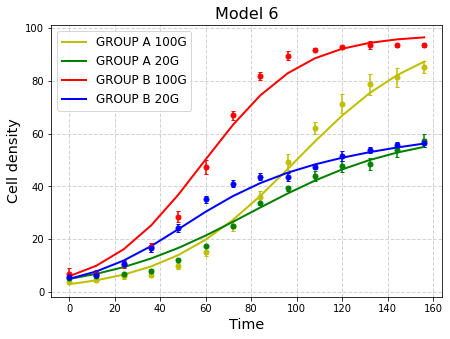

In [48]:
fig, axes = plt.subplots(figsize=(7, 5))

stderr_A_20 = data2.iloc[0:3,:].sem(axis=0)
stderr_B_20 = data2.iloc[3:7,:].sem(axis=0)
stderr_A_100 = data.iloc[0:3,:].sem(axis=0)
stderr_B_100 = data.iloc[3:7,:].sem(axis=0)

axes.grid(color='#D3D3D3', linestyle='--', linewidth=1)
axes.errorbar(time,data_f[:,0],yerr = [stderr_A_100, stderr_A_100],fmt = 'yo', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,1],yerr = [stderr_B_100, stderr_B_100],fmt = 'ro', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,2],yerr = [stderr_A_20, stderr_A_20],fmt = 'go', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,3],yerr = [stderr_B_20, stderr_B_20],fmt = 'bo', ms=5, capsize = 2)

y0 = np.insert(glucose, 0, data_f[0])
sol_6 = odeint(func6, y0, np.array(time), args=(par_sol,))

axes.plot(time,sol_6[:, 0],'y-', linewidth=2,label= 'GROUP A 100G')
axes.plot(time,sol_6[:, 2],'g-', linewidth=2,label= 'GROUP A 20G')
axes.plot(time,sol_6[:, 1],'r-', linewidth=2,label= 'GROUP B 100G')
axes.plot(time,sol_6[:, 3],'b-', linewidth=2,label= 'GROUP B 20G')


axes.set_xlabel("Time", size = "x-large")
axes.set_ylabel("Cell density", size = "x-large")
plt.legend(loc='upper left', fontsize=12)
plt.title("Model 6", fontsize=16)
plt.savefig("./Q3Model6.pdf", format="pdf", bbox_inches="tight", dpi = 300)

##### alpha constant, same between groups (model7)

In [49]:
def func7(xs, t, ps):
    """Migration model."""
    try:
        #A_100
        r01     = ps['r01'].value 
        k1     = ps['k1'].value
        alpha1 = ps['alpha1'].value
        rho1   = ps['rho1'].value
        #B_100
        r02     = ps['r02'].value 
        k2     = ps['k2'].value
        rho2   = ps['rho2'].value
        #A_20
        k3     = ps['k3'].value
        rho3   = ps['rho3'].value
        #B_20
        k4     = ps['k4'].value
        rho4   = ps['rho4'].value
    except:
        r01, k1, alpha1, rho1, r02, k2, rho2, k3, rho3, k4, rho4 = ps

    n1, n2, n3, n4, g1, g2, g3, g4 = xs  #x is Top alive, y is Bottom alive, z is Top dead

    def proliferation_rate(r0,g,rho): #r
        return r0*g/(rho+g)

    def consumption_rate(r,alpha): #m
        return alpha*r


    r1 = proliferation_rate(r01,g1,rho1) #r(g)
    m1 = consumption_rate(r1,alpha1) # m(r)
    dn1dt = r1 * n1 * (1-(n1/k1))
    dg1dt = - m1 * n1 * g1

    r2 = proliferation_rate(r02,g2,rho2) #r(g)
    m2 = consumption_rate(r2,alpha1) # m(r)
    dn2dt = r2 * n2 * (1-(n2/k2))
    dg2dt = - m2 * n2 * g2

    r3 = proliferation_rate(r01,g3,rho3) #r(g)
    m3 = consumption_rate(r3,alpha1) # m(r)
    dn3dt = r3 * n3 * (1-(n3/k3))
    dg3dt = - m3 * n3 * g3

    r4 = proliferation_rate(r02,g4,rho4) #r(g)
    m4 = consumption_rate(r4,alpha1) # m(r)
    dn4dt = r4 * n4 * (1-(n4/k4))
    dg4dt = - m4 * n4 * g4

    return [dn1dt, dn2dt, dn3dt , dn4dt, dg1dt , dg2dt, dg3dt, dg4dt]



def log_likelihood7(params, t, y, g):
    y0 = np.insert(g, 0, y[0])
    sol = odeint(func7, y0, t, args=(params,))
    y_pred = sol[:,0:4]
    error = (y-y_pred).ravel()
    sigma = np.std(error)
    n = len(t)
    f = ((1.0/(2.0*math.pi*sigma*sigma))**(n/2))* \
        np.exp(-1*((np.dot(error.T,error))/(2*sigma*sigma)))
    return -1*np.log(f)


params = Parameters()
params.add('r01', value=0.03, min=0, max = 2)
params.add('k1', value=80, min= 40, max = 110)
params.add('alpha1', value=0.1, min = 0.0001, max=5)
params.add('rho1', value=0.1, min=0.0000001)
params.add('r02', value=0.03, min=0, max = 2)
params.add('k2', value=80, min= 40, max = 110)
params.add('rho2', value=0.1, min=0.0000001)
params.add('k3', value=50, min= 40, max = 110)
params.add('rho3', value=0.1, min=0.0000001)
params.add('k4', value=50, min= 40, max = 110)
params.add('rho4', value=0.1, min=0.0000001)
#vary=True

# fit model and find predicted values
result = minimize(log_likelihood7, params, args=(np.array(time), data_f, glucose), method='BFGS')
result.params

name,value,initial value,min,max,vary
r01,0.03510260,0.03,0.00000000,2.00000000,True
k1,99.1484151,80,40.0000000,110.000000,True
alpha1,1.0000e-04,0.1,1.0000e-04,5.00000000,True
rho1,1.0464e-07,0.1,1.0000e-07,inf,True
r02,0.04611467,0.03,0.00000000,2.00000000,True
k2,97.7554301,80,40.0000000,110.000000,True
rho2,4.3130e-07,0.1,1.0000e-07,inf,True
k3,65.8548598,50,40.0000000,110.000000,True
rho3,5.25659286,0.1,1.0000e-07,inf,True
k4,54.4107517,50,40.0000000,110.000000,True


In [50]:
par_sol = []
for name, param in result.params.items():
    par_sol.append(param.value)

# n is the number of data points
n = len(data_f.ravel())
lk7 = -1*log_likelihood6(par_sol, time, data_f, glucose)
d7 = len(par_sol)


criteria = model_criteria(criteria, "Model7", "AIC", AIC(lk7,d7))
criteria = model_criteria(criteria, "Model7", "BIC", BIC(lk7,d7, n))
criteria

,model,criterion,value
0,Model1,AIC,134.966598
0,Model2,AIC,138.184307
0,Model1,BIC,151.169412
0,Model2,BIC,166.539230
0,Model3,AIC,137.273733
0,Model3,BIC,161.577953
0,Model4,AIC,136.836334
0,Model4,BIC,163.165906
0,Model5,AIC,130.698239
0,Model5,BIC,152.977108


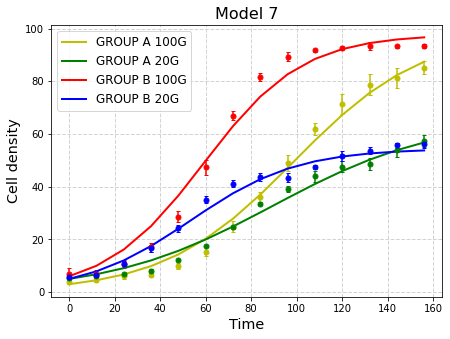

In [51]:
fig, axes = plt.subplots(figsize=(7, 5))

stderr_A_20 = data2.iloc[0:3,:].sem(axis=0)
stderr_B_20 = data2.iloc[3:7,:].sem(axis=0)
stderr_A_100 = data.iloc[0:3,:].sem(axis=0)
stderr_B_100 = data.iloc[3:7,:].sem(axis=0)

axes.grid(color='#D3D3D3', linestyle='--', linewidth=1)
axes.errorbar(time,data_f[:,0],yerr = [stderr_A_100, stderr_A_100],fmt = 'yo', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,1],yerr = [stderr_B_100, stderr_B_100],fmt = 'ro', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,2],yerr = [stderr_A_20, stderr_A_20],fmt = 'go', ms=5, capsize = 2)
axes.errorbar(time,data_f[:,3],yerr = [stderr_B_20, stderr_B_20],fmt = 'bo', ms=5, capsize = 2)

y0 = np.insert(glucose, 0, data_f[0])
sol_7 = odeint(func7, y0, np.array(time), args=(par_sol,))

axes.plot(time,sol_7[:, 0],'y-', linewidth=2,label= 'GROUP A 100G')
axes.plot(time,sol_7[:, 2],'g-', linewidth=2,label= 'GROUP A 20G')
axes.plot(time,sol_7[:, 1],'r-', linewidth=2,label= 'GROUP B 100G')
axes.plot(time,sol_7[:, 3],'b-', linewidth=2,label= 'GROUP B 20G')


axes.set_xlabel("Time", size = "x-large")
axes.set_ylabel("Cell density", size = "x-large")
plt.legend(loc='upper left', fontsize=12)
plt.title("Model 7", fontsize=16)
plt.savefig("./Q3Model7.pdf", format="pdf", bbox_inches="tight", dpi = 300)

#### Comparison of all models

In [52]:
criteria.sort_values("criterion")

,model,criterion,value
0,Model1,AIC,134.966598
0,Model2,AIC,138.184307
0,Model3,AIC,137.273733
0,Model4,AIC,136.836334
0,Model5,AIC,130.698239
0,Model6,AIC,137.021224
0,Model7,AIC,202.132495
0,Model1,BIC,151.169412
0,Model2,BIC,166.539230
0,Model3,BIC,161.577953


**AIC**

In [53]:
crit_AIC = criteria[criteria["criterion"] == "AIC"]
crit_AIC.sort_values("value")

,model,criterion,value
0,Model5,AIC,130.698239
0,Model1,AIC,134.966598
0,Model4,AIC,136.836334
0,Model6,AIC,137.021224
0,Model3,AIC,137.273733
0,Model2,AIC,138.184307
0,Model7,AIC,202.132495


In [54]:
crit_AIC.index = [ i[-1] for i in crit_AIC["model"]]
crit_AIC

,model,criterion,value
1,Model1,AIC,134.966598
2,Model2,AIC,138.184307
3,Model3,AIC,137.273733
4,Model4,AIC,136.836334
5,Model5,AIC,130.698239
6,Model6,AIC,137.021224
7,Model7,AIC,202.132495


**BIC**

In [55]:
crit_BIC = criteria[criteria["criterion"] == "BIC"]
crit_BIC.sort_values("value")

,model,criterion,value
0,Model1,BIC,151.169412
0,Model5,BIC,152.977108
0,Model6,BIC,159.300092
0,Model3,BIC,161.577953
0,Model4,BIC,163.165906
0,Model2,BIC,166.539230
0,Model7,BIC,224.411363


In [56]:
crit_BIC.index = [ i[-1] for i in crit_BIC["model"]]
crit_BIC

,model,criterion,value
1,Model1,BIC,151.169412
2,Model2,BIC,166.539230
3,Model3,BIC,161.577953
4,Model4,BIC,163.165906
5,Model5,BIC,152.977108
6,Model6,BIC,159.300092
7,Model7,BIC,224.411363


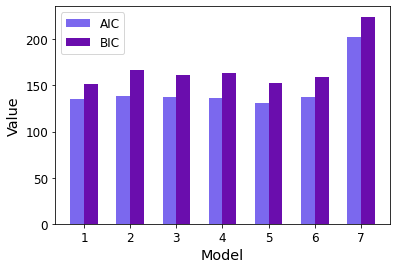

In [57]:
barWidth = 0.3
x1 = list(map(int, crit_AIC.index))
x2 = [x + barWidth for x in x1]

plt.bar(x1, crit_AIC["value"], color ='#7B68EE', width = barWidth, label ='AIC')
plt.bar(x2, crit_BIC["value"], color ='#6A0DAD', width = barWidth, label ='BIC')
plt.xticks([r + 0.5*barWidth for r in x1], x1, size = 'large')
plt.yticks(size = 'large')
plt.xlabel("Model", size = 'x-large')
plt.ylabel("Value", size = 'x-large')
plt.legend(loc = 'upper left',fontsize = 12)
plt.savefig("./Q3ModelSelection2.pdf", format="pdf", bbox_inches="tight", dpi = 300)